In [64]:
from random import random, randint
import math

In [65]:
def wine_price(rating, age):
    peak_age = rating - 50
    
    # Calculate price based on rating.
    price = rating / 2
    if age > peak_age:
        # Past its peak, goes bad in 5 years.
        price = price * (5 - (age - peak_age))
    else:
        # Increases to 5x original value as it approaches the peak.
        price = price * (5 * ((age + 1)/peak_age))
    if price < 0: price = 0
    return price

In [66]:
def wineset1():
    rows = []
    for i in range(300):
        # Create a random age and rating.
        rating = random() * 50 + 50
        age = random() * 50
        
        # Get reference price.
        price = wine_price(rating, age)
        
        # Add some noise.
        price *= (random() * 0.4) + 0.8
        
        # Add to the dataset.
        rows.append({'input': (rating, age),
                     'result': price})
    return rows

In [67]:
wine_price(95.0, 3.0)

21.111111111111114

In [68]:
data = wineset1()
data[0]

{'input': (62.98735913490785, 47.187553134561576), 'result': 0.0}

In [69]:
def euclidean(v1, v2):
    d = 0.0
    for i in range(len(v1)):
        d += (v1[i] - v2[i]) ** 2
    return math.sqrt(d)

In [70]:
euclidean(data[0]['input'], data[1]['input'])

15.735292284281112

In [71]:
def get_distances(data, vec1):
    distances = []
    for i, v in enumerate(data):
        vec2 = v['input']
        distances.append((euclidean(vec1, vec2), i))
    distances.sort()
    return distances

In [72]:
def knn_estimate(data, vec1, k=3):
    # Get sorted distances.
    distances = get_distances(data, vec1)
    avg = 0.0
    
    # Take the average of the top k results.
    for i in range(k):
        idx = distances[i][1]
        avg += data[idx]['result']
    avg = avg / k
    return avg

In [73]:
knn_estimate(data, (99.5, 5.0), k=1)

31.45556332836906

## Weighted Neighbours

- inverse function
- subtraction function
- gaussian function

In [74]:
def inverse_weight(dist, num=1.0, const=0.1):
    return num/(dist+const)

In [75]:
def subtract_weight(dist, const=1.0):
    if dist > const:
        return 0
    return const - dist

In [76]:
def gaussian(dist, sigma=10.0):
    return math.e ** (-dist**2/(2*sigma**2))

In [77]:
distances = [0.1, 1.0]
for j in range(len(distances)):
    print(f'distance={distances[j]} inverse: {inverse_weight(distances[j])} subtract: {subtract_weight(distances[j])} gaussian: {gaussian(distances[j])}')


distance=0.1 inverse: 5.0 subtract: 0.9 gaussian: 0.9999500012499791
distance=1.0 inverse: 0.9090909090909091 subtract: 0.0 gaussian: 0.9950124791926823


In [78]:
def weighted_knn(data, vec1, k=5, weightf=gaussian):
    # Get distances.
    distances = get_distances(data, vec1)
    avg = 0.0
    total_weight = 0.0
    
    # Get weighted average.
    for i in range(k):
        (dist, idx) = distances[i]
        weight = weightf(dist)
        avg += weight * data[idx]['result']
        total_weight += weight
    avg = avg / total_weight
    return avg

In [79]:
weighted_knn(data, (99.0, 5.0))

28.40167996927655

In [80]:
def divide_data(data, test=0.05):
    trainset = []
    testset = []
    for row in data:
        if random() < test:
            testset.append(row)
        else:
            trainset.append(row)
    return trainset, testset

In [81]:
def test_algorithm(algf, trainset, testset):
    error = 0.0
    for row in testset:
        guess = algf(trainset, row['input'])
        error += (row['result'] - guess) ** 2
    if len(testset) == 0 or error == 0: return 0
    return error / len(testset)

In [82]:
def cross_validate(algf, data, trials=100, test=0.05):
    error = 0.0
    for i in range(trials):
        trainset, testset = divide_data(data, test)
        error += test_algorithm(algf, trainset, testset)
    return error / trials

In [83]:
cross_validate(knn_estimate, data)

344.08231149633184

In [84]:
def knn3(d, v): return knn_estimate(d, v, k=3)
cross_validate(knn3, data)

397.9713529418074

In [85]:
cross_validate(weighted_knn, data)

478.7988941390865

In [86]:
def knn_inverse(d, v):
    return weighted_knn(d, v, weightf=inverse_weight)
cross_validate(knn_inverse, data)

350.87181799741563

In [87]:
def wineset2():
    rows = []
    for i in range(300):
        rating = random() * 50 + 50
        age = random() * 50
        aisle = float(randint(1, 20))
        bottlesize = [375.0, 750.0, 1500.0, 3000.0][randint(0, 3)]
        price = wine_price(rating, age)
        price *= (bottlesize/750)
        price *= (random() * 0.9 + 0.2)
        rows.append({'input': (rating, age, aisle, bottlesize), 
                     'result': price})
    return rows

In [88]:
data = wineset2()

In [89]:
cross_validate(knn3, data)

6254.814118485561

In [90]:
cross_validate(weighted_knn, data)

6149.791984375513

In [94]:
def rescale(data, scale):
    scaled_data = []
    for row in data:
        scaled = [scale[i] * row['input'][i] for i in range(len(scale))]
        scaled_data.append({'input': scaled, 'result': row['result']})
    return scaled_data

In [95]:
rescaled = rescale(data, [10, 10, 0, 0.5])
rescaled

[{'input': [989.595674428231, 34.11538033021927, 0.0, 750.0],
  'result': 26.134049582643254},
 {'input': [960.5093767281505, 139.47815297262107, 0.0, 375.0],
  'result': 63.77340053030292},
 {'input': [771.9598833984361, 40.19558666815692, 0.0, 375.0],
  'result': 18.656599602593936},
 {'input': [726.8739050687955, 77.05687605991967, 0.0, 375.0],
  'result': 13.996402069247132},
 {'input': [609.9695638217496, 281.7143878147744, 0.0, 1500.0], 'result': 0.0},
 {'input': [511.28989281236, 281.3758963512603, 0.0, 375.0], 'result': 0.0},
 {'input': [934.7418431016226, 290.2595177212547, 0.0, 187.5],
  'result': 28.02778687124665},
 {'input': [800.9482723660586, 89.80309565297779, 0.0, 1500.0],
  'result': 178.47675509896206},
 {'input': [735.1896884654354, 198.49755139695208, 0.0, 375.0],
  'result': 94.82958807136538},
 {'input': [929.5053523835315, 465.31875510103373, 0.0, 750.0],
  'result': 40.09743052629726},
 {'input': [836.3721771719602, 2.8273697248944463, 0.0, 750.0],
  'result': 

In [96]:
cross_validate(knn3, rescaled)

6214.755380587552

## Optimizing the scale

In [100]:
def create_cost_function(algf, data):
    def costf(scale):
        scaled_data = rescale(data, scale)
        return cross_validate(algf, scaled_data, trials=10)
    return costf

In [99]:
weight_domain = [(0, 20)] * 4

In [101]:
costf = create_cost_function(knn_estimate, data)

In [105]:
# annealing_optimize(weight_domain, costf, step=2)
# genetic_optimize(weight_domain, costf, popsize=5, lrate=1, maxv=4, iters=20)

## Uneven distribution

Problem:
- taking average or weighted average does not work in all situation.
- E.g. when there are two separate group of buyers that purchases the wine, one with the original price, another with 50% discount.
- taking the average will give the average of both groups, which is ~25%.

In [104]:
def wineset3():
    rows = wineset1()
    for row in rows:
        if random() < 0.5:
            # Wine was bought at a discount store.
            row['result'] *= 0.6
    return rows

In [106]:
wine_price(99.0, 20.0)

106.07142857142857

In [107]:
weighted_knn(data, [99.0, 20.0])

163.52850300588793

In [108]:
cross_validate(weighted_knn, data)

5832.38566993779

## Estimating the probability density

Rather than taking the average of the neighbours and getting a single price estimate, it could be more accurate to know the probability that an item fall within a certain price range. 

In this example, given inputs of 99 percent and 20 years, you would like a function that tells you there's a 50% chance that the price is between \$40 and \$80, and a 50% percent chance that it's between \$80 or $100.

In [113]:
def probability_guess(data, vec1, low, high, k = 5, weightf=gaussian):
    distances = get_distance(data, vec1)
    neighbour_weight = 0.0
    total_weight = 0.0
    
    for i in range(k):
        (dist, idx) = distances[i]
        weight = weightf(dist)
        v = data[idx]['result']
        
        # Is this point in the range?
        if v >= low and v <= high:
            neighbour_weight += weight
        total_weight += weight
    if total_weight == 0: return 0
    
    # The probability is the weights in the range divided by all the weights.
    return neighbour_weight / total_weight

In [114]:
probability_guess(data, [99,20], 40, 80)

0.3997321296029781

In [115]:
probability_guess(data, [99,20], 80, 120)

0.0

In [116]:
probability_guess(data, [99,20], 30, 120)

0.5947337817807603

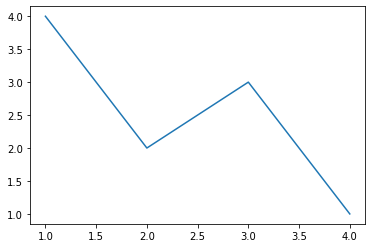

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
a = [1,2,3,4]
b = [4,2,3,1]
plt.plot(a, b)

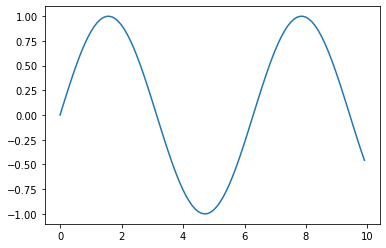

In [127]:
import numpy as np
X = np.arange(0, 10.0, 0.1)
y = np.sin(X)
plt.plot(X, y)

In [132]:
def cumulative_graph(data, vec1, high, k=5, weightf=gaussian):
    t1 = np.arange(0.0, high, 0.1)
    cprob = [probability_guess(data, vec1, 0, v, k, weightf) for v in t1]
    plt.plot(t1, cprob)

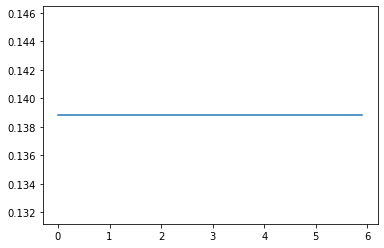

In [134]:
cumulative_graph(data, (1,1), 6)

In [135]:
def probability_graph(data, vec1, high, k=5, weightf=gaussian, ss=5.0):
    # Make a range for the prices.
    t1 = np.arange(0.0, high, 0.1)
    
    # Get the probabilities for the entire range.
    probs = [probability_guess(data, vec1, v, v + 0.1, k, weightf) for v in t1]
    
    # Smooth them by adding the gaussian of the nearby probabilities.
    smoothed = []
    for i in range(len(probs)):
        sv = 0.0
        for j in range(0, len(probs)):
            dist = abs(i - j) * 0.1
            weight = gaussian(dist, sigma=ss)
            sv += weight * probs[j]
        smoothed.append(sv)
    smoothed = np.array(smoothed)
    
    plt.plot(t1, smoothed)

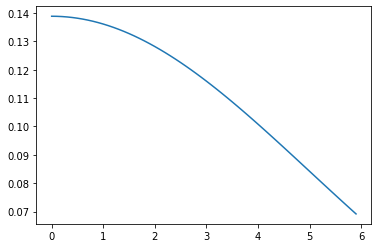

In [136]:
probability_graph(data, (1,1), 6)